# 

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./src')

from src.data import load_data_part1, CustomAnalyzer
from src.eval import print_score
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

Load d'un modèle optimisé

In [2]:
d = joblib.load("./part1_speaker_recognition/gridsearch/results/part1_hrscv_LogisticRegression_mcc.pkl")

X, y = load_data_part1()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
pipeline = d.best_estimator_
pipeline.fit(X_train, y_train)
print(y_train)
y_hat = pipeline.predict(X_test)

[1 1 1 ... 1 1 1]


In [3]:
def countValue(l):
    d = {-1:0, 1:0}
    for v in l:
        # d[v] = d.get(v, 0) + 1
        d[v] += 1
    return d

def windows_post(y, size=1, threshold=2):
    """
    Convolue sur la liste et regarde le nombre de voisin dans la fenêtre centré sur le point.
    Attribue simple la classe la plus présente dans la fenêtre au point centré.
    """
    new_y = y.copy()
    for i in range(size, len(y) - size):
        window = y[i - size : i + size + 1]
        d = countValue(window)
        if d[-1] < d[1]:
            new_y[i] = 1
        elif d[-1] > d[1]:
            new_y[i] = -1
        else:
            pass
    return new_y

# Testing for manual visualization
# one_windows_y_hat = windows_post(y_hat)
# two_windows_y_hat = windows_post(y_hat, size=2)
# three_windows_y_hat = windows_post(y_hat, size=3)
# four_windows_y_hat = windows_post(y_hat, size=4)
# one_two_windows_y_hat = windows_post(one_windows_y_hat, size=2)
# df = pd.DataFrame({
#     "True Label": y_test,
#     "Prediction": y_hat,
#     # "Size=1": one_windows_y_hat,
#     # "Size=2": two_windows_y_hat,
#     # "Size=3": three_windows_y_hat,
#     # "Size=4": four_windows_y_hat,
#     # "size=1 then 2": one_two_windows_y_hat
# })

Impact de la taille de la fenêtre : plusieurs convolution en augmentant la taille de la fenètre (noyaux variable)

In [4]:
tmp = y_hat
lx, ly = [], []
for i in range(0, 10):
    tmp = windows_post(tmp, size=i)
    f1 = f1_score(y_test, tmp, pos_label=-1)
    lx.append(i)
    ly.append(f1)
# plt.plot(lx, ly)

Noyaux fixe avec baseline en 0

In [5]:
lx2, ly2 = [], []
for i in range(0, 10):
    tmp = windows_post(y_hat, size=i)
    f1 = f1_score(y_test, tmp, pos_label=-1)
    lx2.append(i)
    ly2.append(f1)

Passer plusieurs fois un noyaux de taille fixe

In [6]:
tmp = y_hat
lx3, ly3 = [], []
for i in range(0, 10):
    tmp = windows_post(tmp, size=3)
    f1 = f1_score(y_test, tmp, pos_label=-1)
    lx3.append(i)
    ly3.append(f1)

Passer un noyaux de taille fixe plusieurs fois n'a pas d'impact.

Dataviz

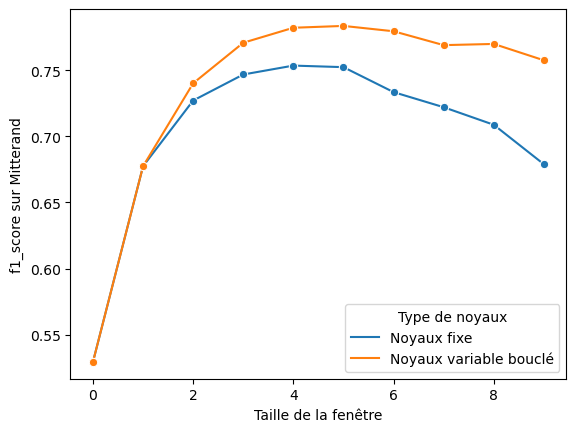

In [7]:
df = pd.DataFrame({
    "Taille de la fenêtre": lx,
    "Noyaux fixe" : ly2,
    "Noyaux variable bouclé": ly
})
df_long = pd.melt(df, id_vars="Taille de la fenêtre", value_name="f1_score sur Mitterand", var_name="Type de noyaux")
sns.lineplot(data=df_long, x="Taille de la fenêtre", y="f1_score sur Mitterand", hue="Type de noyaux", marker="o")
plt.savefig("./final_report/kernel_type_impact.png")


    Baseline :
    =====
    Macro F1-score : 0.7267612557779171
    Micro F1-score : 0.8692350564302633
    Macro ROC-AUC: 0.7962585965458223
    Weighted ROC-AUC: 0.7962585965458223
    Classification report :
                  precision    recall  f1-score   support

          -1       0.42      0.70      0.53      1500
           1       0.96      0.89      0.92     12854

    accuracy                           0.87     14354
   macro avg       0.69      0.80      0.73     14354
weighted avg       0.91      0.87      0.88     14354

    =====
    

    Best résult w/ postprocessing on test :
    =====
    Macro F1-score : 0.8722929341622452
    Micro F1-score : 0.9531141145325345
    Macro ROC-AUC: 0.8651748871946476
    Weighted ROC-AUC: 0.8651748871946476
    Classification report :
                  precision    recall  f1-score   support

          -1       0.79      0.75      0.77      1500
           1       0.97      0.98      0.97     12854

    accuracy                   

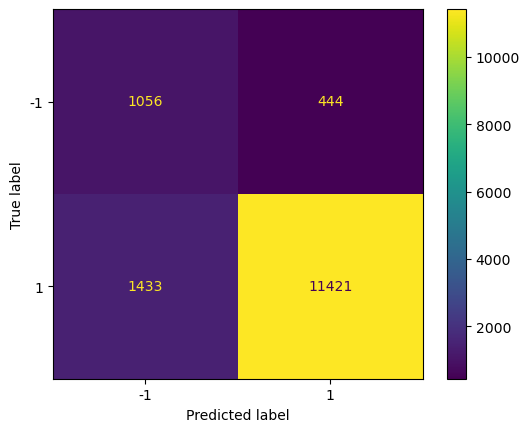

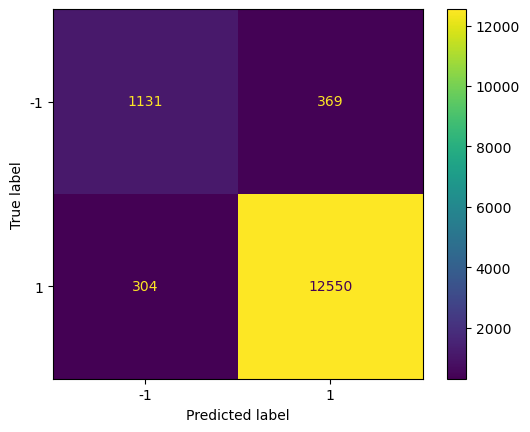

In [19]:
tmp = windows_post(y_hat)
for i in range(2, 4):
    tmp = windows_post(tmp, size=i)
print_score(y_test, y_hat, "Baseline")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat), display_labels=pipeline.classes_).plot()

print_score(y_test, tmp, "Best résult w/ postprocessing on test")
ConfusionMatrixDisplay(confusion_matrix(y_test, tmp), display_labels=pipeline.classes_).plot()


**On transforme surtout des -1 en 1.** Il faudrait être plus sensible sur l'inverse

# Recherche pour utiliser le niveau de confiance dans la correction

In [9]:
# C'est le résultat de la fonction de décision, si négatif on prédit -1, sinon 1 
confidence_score_test = pipeline.decision_function(X_test)
confidence_score_test = pd.Series(confidence_score_test)
df['confidence'] = confidence_score_test

<Axes: >

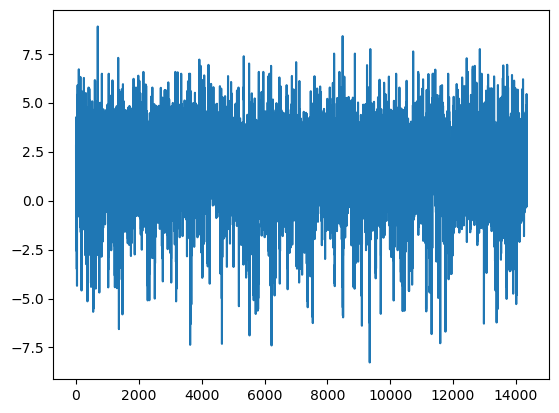

In [10]:
confidence_score_test.plot()

<Axes: >

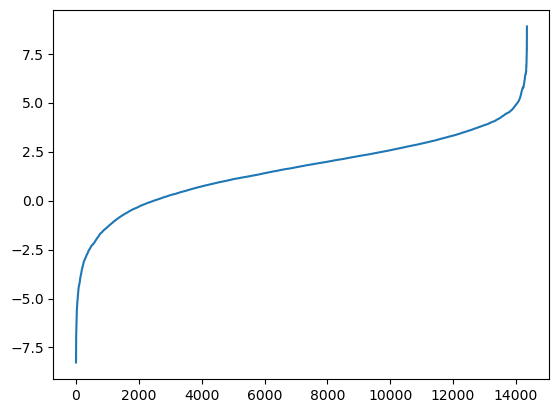

In [11]:
confidence_score_test.sort_values().reset_index(drop=True).plot()

In [12]:
confidence_score_test.describe()

count    14354.000000
mean         1.593519
std          1.886137
min         -8.265455
25%          0.547357
50%          1.753883
75%          2.829298
max          8.888763
dtype: float64

<Axes: >

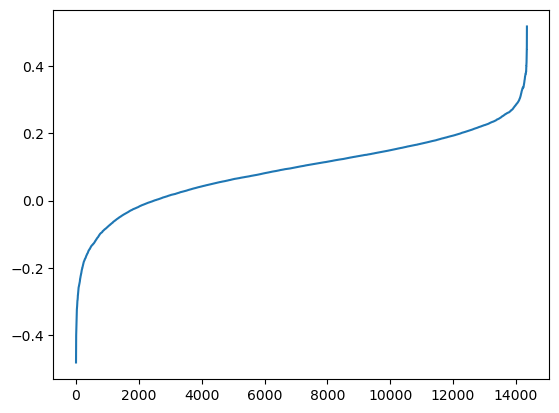

In [13]:
min_v = confidence_score_test.min()
mean_v = confidence_score_test.mean()
max_v = confidence_score_test.max()
conf_norm = pd.Series((confidence_score_test) / (max_v - min_v) )
conf_norm.sort_values().reset_index(drop=True).plot()

In [14]:
# C'est le résultat de la fonction de décision, si négatif on prédit -1, sinon 1 
confidence_score_train = pipeline.decision_function(X_train)
confidence_score_train = pd.Series(confidence_score_test)

<Axes: >

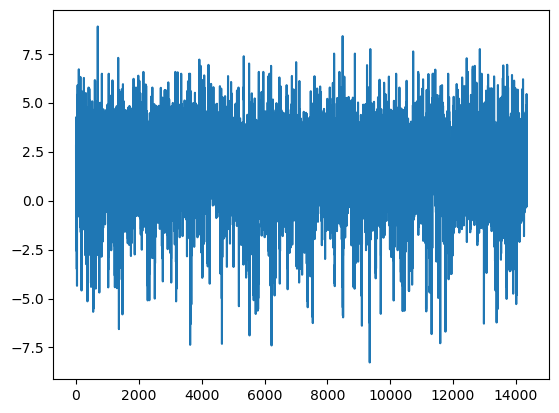

In [15]:
confidence_score_train.plot()

In [16]:
a = df['True Label'] == 1
b = df['True Label'] == -1
c = df['Prediction'] == 1
d = df['Prediction'] == -1

KeyError: 'True Label'

Bonne prédiction sur 1

In [ ]:
df.loc[a & c, "confidence"].describe()

count    11630.000000
mean         2.235256
std          1.214077
min          0.001125
25%          1.335719
50%          2.168341
75%          3.027188
max          8.412547
Name: confidence, dtype: float64

Bonne prédiction sur -1

In [ ]:
df.loc[b & d, "confidence"].describe()

count    1024.000000
mean       -2.064530
std         1.450564
min        -8.094947
25%        -2.838144
50%        -1.865650
75%        -0.914479
max        -0.004546
Name: confidence, dtype: float64

Mauvaise prédiction sur 1 (prédit -1 alors que 1)

In [ ]:
df.loc[a & d, "confidence"].describe()

count    1224.000000
mean       -0.861998
std         0.770110
min        -4.755993
25%        -1.253275
50%        -0.659177
75%        -0.292799
max        -0.000007
Name: confidence, dtype: float64

Mauvaise prédiction sur -1 (prédit 1 alors que -1)

In [ ]:
df.loc[b & c, "confidence"].describe()

count    476.000000
mean       1.125645
std        0.861987
min        0.000329
25%        0.412199
50%        0.932317
75%        1.615536
max        5.089572
Name: confidence, dtype: float64